## FitzHugh-Nagumo

We will look at a statistical inference problem using our KalmanODE solver. 

- The **FitzHugh-Nagumo** ODE model is

    $$
    \frac{dV_t}{dt} = c(V_t - V_t^3/3 + R_t), \qquad \frac{d R_t}{dt} = -(V_t - a + b R_t)/c.
    $$

- The true parameter values are $a = .2$, $b = .2$, $c = 3$.

- The initial value is $x_0=(-1,1)$. 

- The parameter priors are $\theta_j \stackrel{ind}{\sim} \mathrm{LogNormal}(\theta_{\star j}, 1)$, where $\theta_j \in \{a, b, c\}$ and $\theta_{\star j}$ is the corresponding true parameter value.

- Data is observed at time points $t = 1, 2, \ldots, 40$, with some error.  That is,

    $$
    y_{1n} \stackrel{ind}{\sim} \mathcal N(V_n, .01^2), \qquad y_{2n} \stackrel{ind}{\sim} \mathcal N(R_n, .01^2) 
    $$

- The step sizes for the discretization are $h = (.005, .01, .02, .05, .1)$.

In [5]:
import numpy as np
from fitz.fitz_plot import fitz_plot
from probDE.car import car_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init

In [6]:
def fitz(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    V, R = X_t[0], X_t[n_state1]
    return np.array([c*(V - V**3/3 + R), -1/c*(V - a + b*R)])

Next we will define the usual parameters required to run our solver.

In [7]:
# These parameters define the order of the ODE and the CAR(p) process
n_state1 = 3 # State dimension of V_n
n_state2 = 3 # State dimension of R_n
n_state = 6 # Total state
n_meas = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
h = 0.1 # step size
n_eval = int((tmax-tmin)/h)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, a, for the IVP
x0 = [-1, 1]
v0 = [1, 1/3]
X0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# logprior parameters
theta_true = np.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_sd = np.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

First we need some data to do parameter inference. We will simulate the data using the deterministic solver **odeint**.

In [8]:
# Initialize fitz_plot class and simulate observed data
fplot = fitz_plot(n_state1, tmin, tmax)
Y_t, X_t = fplot.simulate(x0, theta_true, gamma)

For a comparison, we will use the Euler's approximation method to demonstrate the effectiveness of our solver.

In [7]:
# Euler simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_euler = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    phi_hat, phi_var = fplot.phi_fit(fplot.euler_nlpost, Y_t, x0, hlst[i], theta_true, phi_sd, gamma)
    Theta_euler[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

Finally, we will our solver to do parameter inference.

In [13]:
# Kalman simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], hlst[i], w_mat[0], X0[0]),
                                  car_init(n_state2, tau[1], sigma[1], hlst[i], w_mat[1], X0[1])],
                                  n_state)
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz, **kinit)
    fplot.kode = kode
    phi_hat, phi_var = fplot.phi_fit(fplot.kalman_nlpost, Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma)
    Theta_kalman[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

In the plot below, we can see that the step size needs to be a lot smaller, $h=0.02$ for Euler's method to cover the true $\theta_2$, while our solver only requires $h=0.1$.

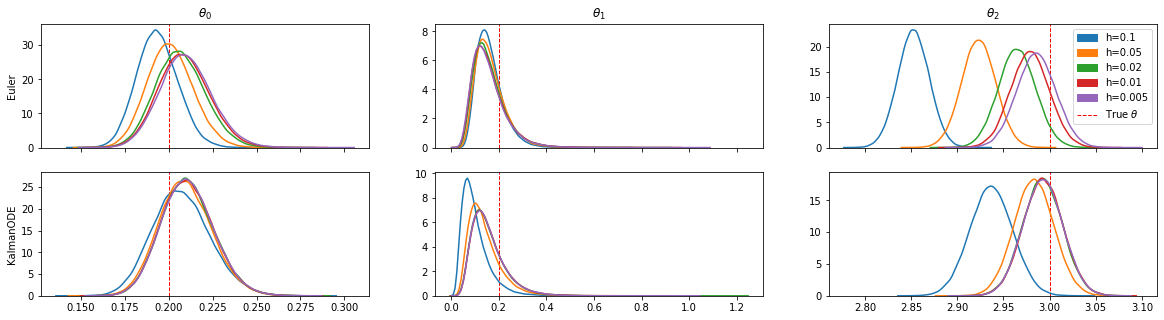

In [14]:
# Euler, Kalman plots
fplot.theta_plot(Theta_euler, Theta_kalman, theta_true, hlst)